<a href="https://colab.research.google.com/github/ArturGogiyan/NLP_research/blob/master/NLP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/datasets/dataset_research.csv') 

print("Shape of data=>",df.shape)

Shape of data=> (5000, 6)


# Exploratory data analysis

Создание списка всех лейблов, присутствующих в данных

In [ ]:
comment_labels = {}
comment_labels_combinations = {}
unique_labels = set()
unique_labels_combinations = set()

for i, row in df.iterrows():
    label_index = 0
    k = 0
    for j, cell in row.items():
        if str(cell)[:6] == '[\'824.':
            label_index = k
            break
        k+=1


    labels = row[k][1:-1].split(',')

    comment = ' '.join(row[:k])
    row['comment'] = comment
    for j, label in enumerate(labels):
        label_stripped = label.strip()[5:-3]
        labels[j] = label_stripped
        if label_stripped not in unique_labels:
            unique_labels.add(label_stripped)
    labels_combination = ' & '.join(labels)
    if labels_combination not in unique_labels_combinations:
       unique_labels_combinations.add(labels_combination)
    comment_labels[i] = labels
    comment_labels_combinations[i] = labels_combination

создание pandas.dataframe с разреженным вектором фич, где каждая колонка - отдельный лэйбл

In [ ]:
df_unique_combinations = df[['comment']].copy()
for label in unique_labels:
  df[label] = 0
for label_combination in unique_labels_combinations:
  df_unique_combinations[label_combination] = 0

In [ ]:
df = df.drop(df.columns[[1, 2, 3, 4, 5]], axis=1)

In [ ]:
for index, labels in comment_labels.items():
  for label in labels:
    df.at[index, label] = 1

for index, label_combination in comment_labels_combinations.items():
  for label in label_combination:
    df_unique_combinations.at[index, label_combination] = 1

вывод первых 5 записей отформатированного датафрейма

In [ ]:
df.head(5)

,comment,account-management.account-access,attributes.cleanliness,company-brand.convenience,online-experience.language,purchase-booking-experience.choice-variety,logistics-rides.speed,staff-support.email,staff-support.agent-named,online-experience.updates-versions,company-brand.general-satisfaction,account-management.fingerprint-facial-recognition,attributes.size-fit,logistics-rides.order-accuracy,attributes.taste-flavour,company-brand.competitor
0,"easy, very accessible",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Just a horrible app with a sign up experience ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Downloaded the latest update and it still logs...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Since latest update from Apple for the iPhone ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Shockingly bad since the update, I had to rein...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_unique_combinations.head(5)

,comment,account-management.fingerprint-facial-recognition & account-management.account-access & company-brand.general-satisfaction,online-experience.language,logistics-rides.speed,company-brand.general-satisfaction & purchase-booking-experience.choice-variety,company-brand.convenience & company-brand.competitor,online-experience.updates-versions,company-brand.convenience & purchase-booking-experience.choice-variety,account-management.account-access & online-experience.updates-versions,company-brand.general-satisfaction & company-brand.convenience,account-management.account-access & company-brand.general-satisfaction & company-brand.competitor,company-brand.general-satisfaction & staff-support.email,company-brand.competitor & company-brand.general-satisfaction,company-brand.general-satisfaction & logistics-rides.speed,attributes.cleanliness,purchase-booking-experience.choice-variety,account-management.account-access & company-brand.general-satisfaction & online-experience.updates-versions,account-management.fingerprint-facial-recognition & company-brand.convenience,company-brand.general-satisfaction & company-brand.competitor,company-brand.general-satisfaction,attributes.size-fit,logistics-rides.order-accuracy,company-brand.general-satisfaction & online-experience.updates-versions,company-brand.convenience & company-brand.general-satisfaction,company-brand.competitor,account-management.fingerprint-facial-recognition & account-management.account-access & company-brand.convenience,account-management.account-access & company-brand.competitor,staff-support.agent-named,account-management.fingerprint-facial-recognition & company-brand.general-satisfaction,account-management.account-access & company-brand.convenience & online-experience.updates-versions,logistics-rides.speed & purchase-booking-experience.choice-variety,company-brand.general-satisfaction & company-brand.competitor & purchase-booking-experience.choice-variety,staff-support.email,attributes.size-fit & online-experience.updates-versions,attributes.size-fit & company-brand.general-satisfaction,account-management.fingerprint-facial-recognition & online-experience.updates-versions,company-brand.convenience & online-experience.updates-versions,account-management.account-access & company-brand.convenience,account-management.account-access,company-brand.convenience,company-brand.competitor & online-experience.updates-versions,account-management.fingerprint-facial-recognition & account-management.account-access,account-management.fingerprint-facial-recognition,account-management.account-access & company-brand.general-satisfaction,account-management.fingerprint-facial-recognition & account-management.account-access & online-experience.updates-versions,attributes.taste-flavour,company-brand.general-satisfaction & online-experience.language,company-brand.general-satisfaction & company-brand.competitor & online-experience.updates-versions
0,"easy, very accessible",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Just a horrible app with a sign up experience ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Downloaded the latest update and it still logs...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Since latest update from Apple for the iPhone ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"Shockingly bad since the update, I had to rein...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на количество пустых полей в датасете

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   comment                                            5000 non-null   object
 1   account-management.account-access                  5000 non-null   int64 
 2   attributes.cleanliness                             5000 non-null   int64 
 3   company-brand.convenience                          5000 non-null   int64 
 4   online-experience.language                         5000 non-null   int64 
 5   purchase-booking-experience.choice-variety         5000 non-null   int64 
 6   logistics-rides.speed                              5000 non-null   int64 
 7   staff-support.email                                5000 non-null   int64 
 8   staff-support.agent-named                          5000 non-null   int64 
 9   online-experience.u

Получим частоты лейблов в датасете

In [ ]:
feature_freqs =  df.sum(axis = 0, skipna = True)[1:].sort_values(ascending=True)

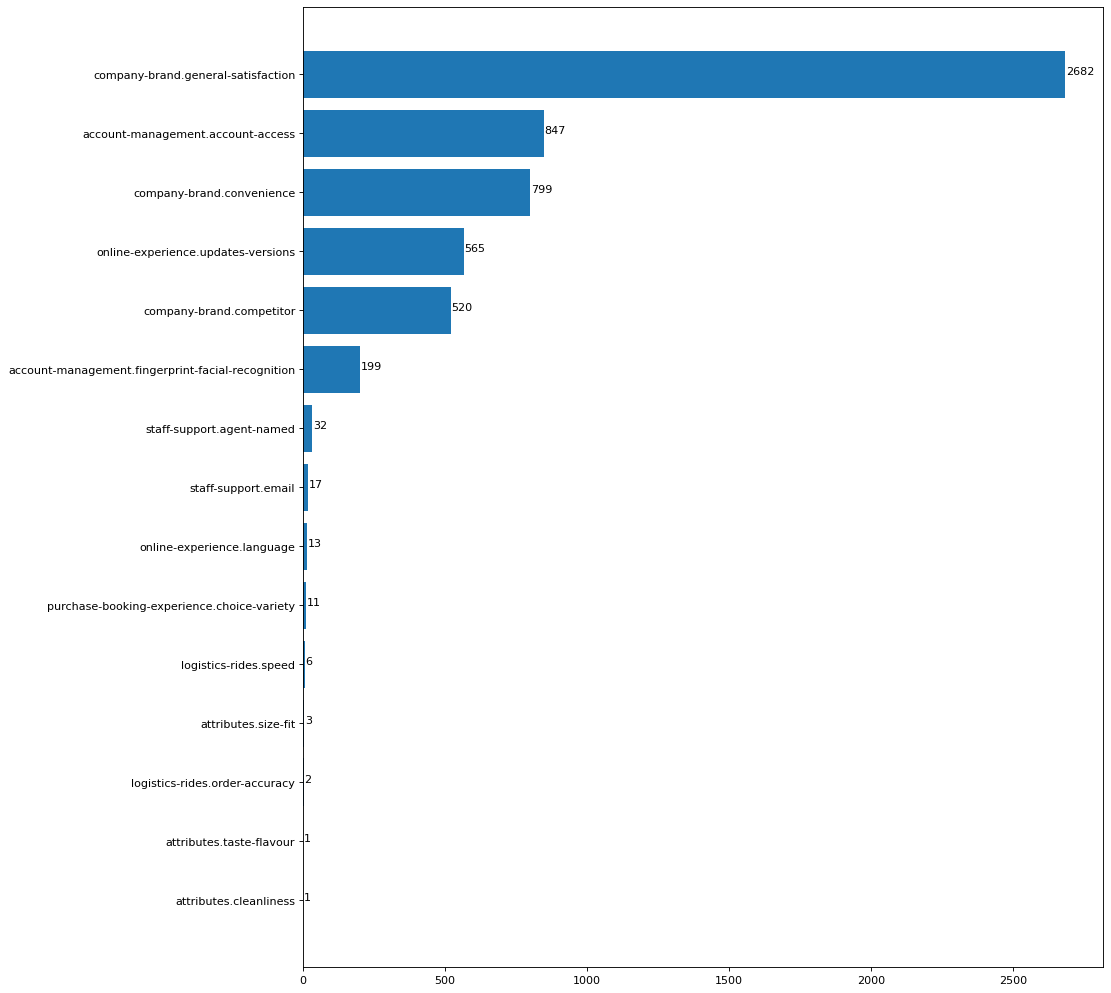

In [ ]:
fig = plt.figure(figsize=(10, 12), dpi=80)
plt.xlabel('feature')
plt.ylabel('frequency')
plt.title('frequency of different features in applied dataset')

ax = fig.add_axes([0,0,1,1])
ax.barh(feature_freqs.keys(),feature_freqs.values)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(feature_freqs.values):
    ax.text(v + 3, i, str(v))

plt.show()

как видно, датасет не сбалансирован: для некоторых лэйблов существует лишь по несколько записей.
К примеру, лэйблы **attributes.cleanliness** и **attributes.taste-flavour** представленны лишь в 1 записи.

Рассмотрим распределение комментариев по сочетаниям лейблов

In [ ]:
feature_freqs_combinations =  df_unique_combinations.sum(axis = 0, skipna = True)[1:].sort_values(ascending=True)

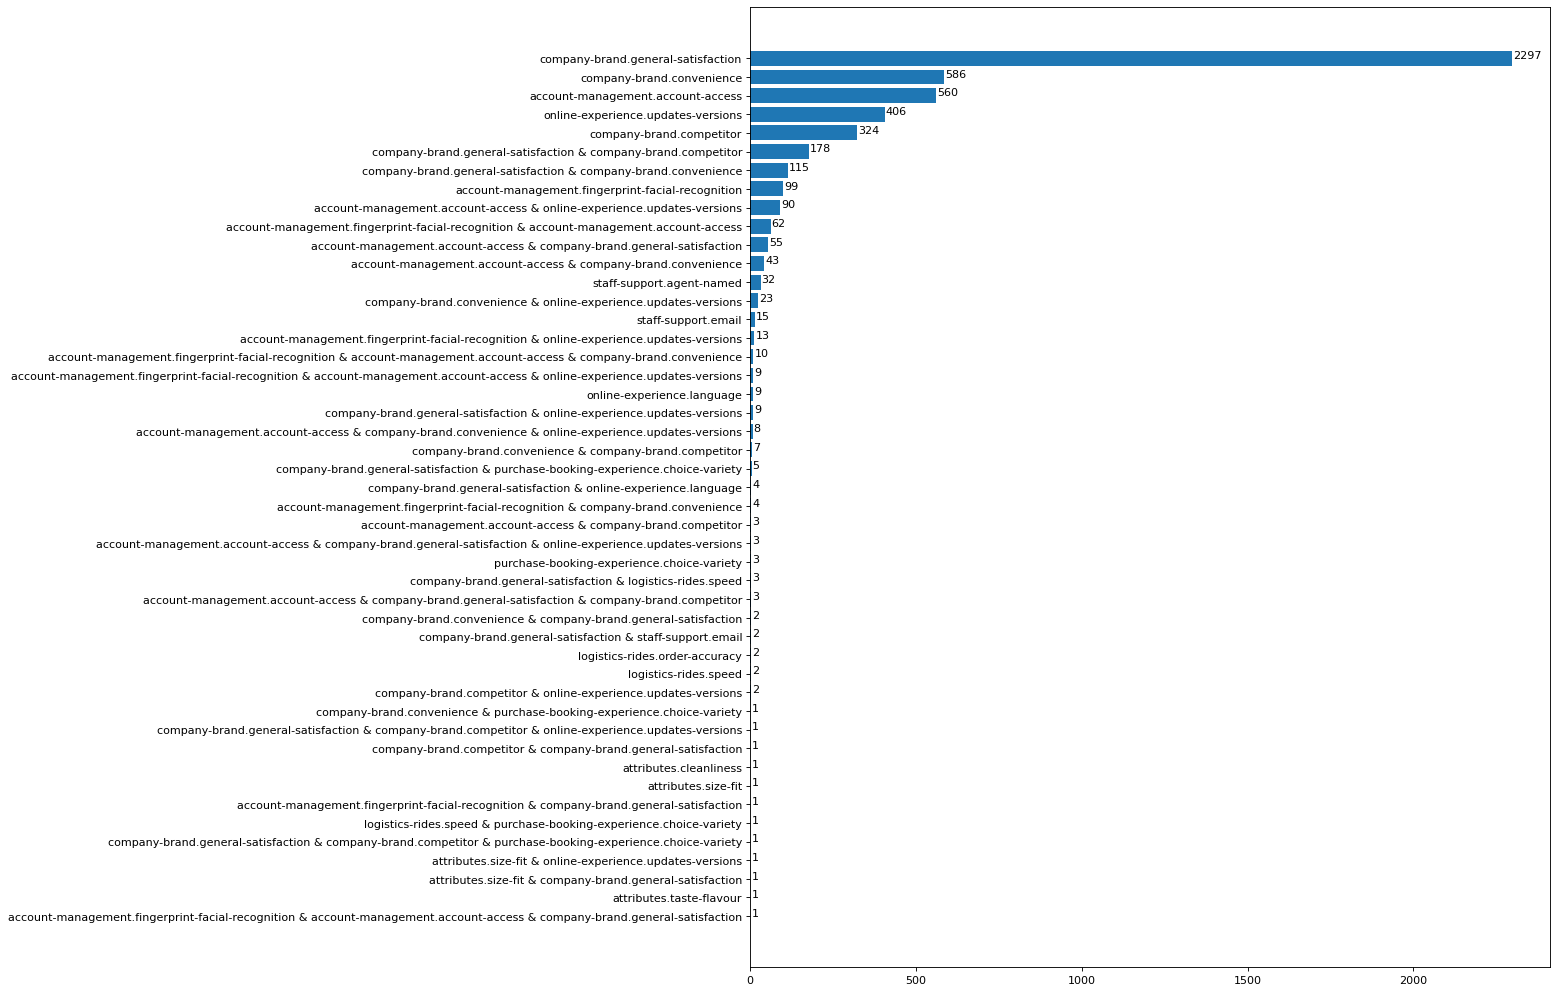

In [ ]:
fig = plt.figure(figsize=(10, 12), dpi=80)
plt.xlabel('feature')
plt.ylabel('frequency')
plt.title('frequency of different features in applied dataset')

ax = fig.add_axes([0,0,1,1])
ax.barh(feature_freqs_combinations.keys(),feature_freqs_combinations.values)

xlocs, xlabs = plt.xticks()
for i, v in enumerate(feature_freqs_combinations.values):
    ax.text(v + 3, i, str(v))

plt.show()

# Non-neural network processing

Resources needed:

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from random import shuffle
%matplotlib inline
nltk.download('wordnet')
minimum_classes = 600

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Lemmatization

In [ ]:
def make_lemmas(tokens):
    return ' '.join(list(map(lambda t: lemmatizer.lemmatize(t), tokens)))
def preprocess(text):
    return re.findall(re.compile(r'[A-ZА-Яa-zа-яёË]+'), text.lower())
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_train_and_test(class_name, test_percentage):
    if test_percentage > 0 and test_percentage <= 100:
        texts = []
        Ys = []
        for index, row in df.iterrows():
            texts.append(row['comment'])
            Ys.append(row[class_name])

        ys_chk = 0
        for ys in Ys:
            ys_chk +=ys
        if ys_chk < minimum_classes:
            return [], [], [], []

        test_size   = int(len(texts) * test_percentage / 100)
        train_size  = len(texts) - test_size
        texts_train = texts[:train_size]
        texts_test  = texts[:-test_size]
        y_train     = Ys[:train_size]
        y_test      = Ys[:-test_size]
        texts_train = [make_lemmas(preprocess(text=text)) for text in texts_train]
        texts_test  = [make_lemmas(preprocess(text=text)) for text in texts_test]
        
        return texts_train, texts_test, y_train, y_test

## Bag of Words implementation

In [ ]:
class bag_of_words:
    def __init__(self, texts, K = 0):
      k = 0
      if K > 0:
          k = K
      else:
        k = len(set(' '.join(texts).split()))
      bag = dict()
      for comment in texts:
          for word in comment.split(' '):
              if word not in bag.keys():
                  bag[word] = 1
              else:
                  bag[word] += 1
      self.bow_vocabulary = dict(sorted(bag.items(), key=lambda item: item[1], reverse=True)[:k])


    def bow_vocabulary(self):
      return self.bow_vocabulary

    def text_to_bow(self, text):
        bow = [0] * len(self.bow_vocabulary)
        voc_map = dict()

        for num, w in enumerate(self.bow_vocabulary, start=0):
            voc_map[w] = num

        for token in text.split(' '):
            if token in voc_map:
                bow[voc_map[token]] += 1

        return np.array(bow, 'float32')

    

## Naive Bayes Classifier

In [ ]:
class BinaryNaiveBayes:
    delta = 1.0
    
    def fit(self, X, y):
        self.p_y = np.array([sum(c == 0 for c in y) / len(y), sum(c == 1 for c in y) / len(y)], 'float32')
        
        word_counts_positive = [0] * len(X[0])
        word_counts_negative = [0] * len(X[0])
        
        for t in range(len(y)):
            if y[t] == 1:
                for x in range(len(X[t])):
                    word_counts_positive[x] += X[t][x]
            else:
                for x in range(len(X[t])):
                    word_counts_negative[x] += X[t][x]

        self.p_x_given_positive = [0.0] * len(word_counts_positive)
        self.p_x_given_negative = [0.0] * len(word_counts_negative)
        
        for i in range(len(word_counts_positive)):
            self.p_x_given_positive[i] = (word_counts_positive[i] + self.delta) / sum(word_counts_positive)
            self.p_x_given_negative[i] = (word_counts_negative[i] + self.delta) / sum(word_counts_negative)

        return self
    
    def predict_scores(self, X):

        p_x_given_negative_lg = list(map(lambda p: np.log(p), self.p_x_given_negative))
        p_x_given_positive_lg = list(map(lambda p: np.log(p), self.p_x_given_positive))

        score_negative = [np.log(self.p_y[0]) + np.dot(p_x_given_negative_lg, x) for x in X]
        score_positive = [np.log(self.p_y[1]) + np.dot(p_x_given_positive_lg, x) for x in X]
        return np.stack([score_negative, score_positive], axis=-1)
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [ ]:
def bayes_test(class_name, test_percentage):
    print("\'"+class_name+"\' MODEL:")
    texts_train, texts_test, y_train, y_test = get_train_and_test(class_name, test_percentage)
    if len(texts_train) == 0:
        print ("Class entities amount is too small! Ignoring...")
        return [], [], []

    bow = bag_of_words(texts_train)
    #bow_vocabulary = make_bow_vocabulary(texts_train)
    X_train_bow = np.stack(list(map(bow.text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(bow.text_to_bow, texts_test)))

    naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

    ret = naive_model.predict(X_test_bow)
    test_accuracy = np.mean(ret == y_test)
    print(f"Model accuracy: {test_accuracy:.3f}")
    for name, X, y, model in [
    (class_name+'train', X_train_bow, y_train, naive_model),
    (class_name+'test ', X_test_bow, y_test, naive_model)
    ]:
        for y_temp in y:
            if np.isnan(y_temp):
                y_temp = 0
            if np.isinf(y_temp):
                y_temp = 1
        proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()
    
    return texts_test, ret, y_test

In [ ]:
def make_bayes_models(test_percentage):

    classes = (list(df.columns.values))
    classes.pop(0)
    i = 1
    bayes_result = []
    bayes_df = pd.DataFrame()
    for c in classes:
        try:
            new_plt = plt.subplot(1, 1, i)
            test_text, predicted_y, correct_y = bayes_test(c, test_percentage)
            if len(test_text) > 0:
              i+=1
              if len(bayes_result) == 0:
                    bayes_result.append(test_text)
                    bayes_df["Data"] = test_text
              correct_incorrect = []
              for y_ind in range(len(predicted_y)):
                  if predicted_y[y_ind] == correct_y[y_ind]:
                      correct_incorrect.append("+")
                  else:
                      correct_incorrect.append("-")
              bayes_result.append(correct_incorrect)
              bayes_df[c] = correct_incorrect

        except:
          print(c+" error!")
    return bayes_df

In [ ]:
bayes_df = make_bayes_models(1)
bayes_classes = (list(bayes_df.columns.values))
bayes_classes.pop(0)
bayes_classes
total_sz = 0.0
correct_sz = 0.0

i = 0

for ind in bayes_df.index:

    total_sz += 1
    correct = True
    for c in bayes_classes:
      if bayes_df[c][ind] == '-':
        correct = False
        break
    if correct == True:
      correct_sz += 1

print("Overall efficiency:"+"{:.2f}".format(correct_sz / total_sz))

## Logistic regression